## Gesture Recognization 
##### Khan Imran Jabbar


In [1]:
# Importing necessary libraries
import numpy as np
import os
from imageio.v2 import imread
from skimage.transform import resize
import datetime
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import pandas as pd
from tensorflow import keras


In [2]:
# Setting Random Seed
np.random.seed(30)
import random as rn
rn.seed(30)
tf.random.set_seed(30)

In [3]:
# Reading in the CSV that contains the information about our training and validaton data
train_doc = np.random.permutation(open('datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('datasets/Project_data/val.csv').readlines())


#### A Quick look at the data before we start the modeling process


In [4]:
# Reading in the CSV as DataFrame
#Assigning column names as the CSV doesn't contain a header
colnames=["Folder","Action","labels"] 
train_df =pd.read_csv("datasets/Project_data/train.csv",sep=';', names=colnames ) 
val_df =pd.read_csv("datasets/Project_data/val.csv",sep=';', names=colnames )   

In [5]:
print("Shape of Train : ",train_df.shape)
print("Shape of Val : ",val_df.shape)


Shape of Train :  (663, 3)
Shape of Val :  (100, 3)


In [6]:
# We have 663 rows in train df and 100 inn val df which correspond to the number of folders we have in our 
#training and validation dataset, so its clear that the csv are picking up the right number of files

# Cheking if class labels are assigned properly in the train CSV
train_df.groupby("Action")['labels'].value_counts()

Action                         labels
Left Swipe_new_Left Swipe_new  0          40
Left_Swipe_new                 0          96
Right Swipe_new                1          34
Right_Swipe_new                1         103
Stop Gesture_new               2          37
Stop_new                       2          93
Thumbs Down_new                3          37
Thumbs Up_new                  4          36
Thumbs_Down_new                3         100
Thumbs_Up_new                  4          87
Name: labels, dtype: int64

In [7]:
# The CSV has multiple names for the same action, but the class labels are correct.
#No preprocessing required as only labels are being used for Training 

In [8]:
# Cheking if class labels are assigned properly in the validation csv
val_df.groupby("Action")['labels'].value_counts()

Action                         labels
Left Swipe_new_Left Swipe_new  0          5
Left_Swipe_new                 0         13
Right Swipe_new                1         10
Right_Swipe_new                1         13
Stop Gesture_new               2          8
Stop_new                       2         14
Thumbs Down_new                3          9
Thumbs Up_new                  4          6
Thumbs_Down_new                3         12
Thumbs_Up_new                  4         10
Name: labels, dtype: int64

In [9]:
# As with the training csv, the validation csv also has multiple name for same labels. No preprocessing required 
# as only labels are being used for validation 

In [10]:
# Creating a dictionary with class name and labels- To be used during model evaluation
classname =	{"Swipe Left": 0,"Swipe Right":1,"Stop": 2,"Thumbs Down": 3,"Thumbs Up": 4}

In [11]:
# Checking Class distribution for training set (Multiplied by 30 as each folder has 30 images)
train_df["labels"].value_counts()*30

1    4110
3    4110
0    4080
2    3900
4    3690
Name: labels, dtype: int64

In [12]:
# There is a small class imbalance with class 1 and 3 having the highest number of 
# samples followed by class 0, class 2 and class respectively. The imbalance is not extremely large 
# hence we won't be correcting the imbalance

# Data Generator
#### Step 1 ) Create Generator
#### Step 2) Test Generator

In [13]:
# This function will be used to create batch data to be fed to the Neural network
#The generator function takes folder list, batch size , image dimension and image index as input
# and outputs data of shape (batchsize,lengthofimageindex, image dimension(in Height,width format)
# and channels) along with the data's label in one-hot encoded format

def generator(source_path, folder_list, batch_size,imgdim,img_idx):
    print() # blank line
    print( 'Source path = ', source_path, '; batch size =', batch_size)

  
    while True:
        t = np.random.permutation(folder_list)
        
        # Calculating the number of batches needed to run through the data once
        num_batches = len(folder_list) // batch_size
        
        # Storing the number of leftover folder to be added to the batch after all full batches
        # are yielded
        leftover=len(folder_list)% batch_size
    
        for batch in range(num_batches):      
            batch_data = np.zeros((batch_size,len(img_idx),imgdim,imgdim,3))   
            batch_labels = np.zeros((batch_size,5))                                
            for folder in range(batch_size):                                         
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
                for idx,item in enumerate(img_idx):         
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image= resize(image,[imgdim,imgdim]) #----- Resize the image to dimension passed by variable imgdim
                    
                    # Normalizing each channel
                    # Three normalization techniques were experimented with
                    ## 1 - (image−np.min(image))/(np.max(image)−np.min(image))
                    ## 2 - (image−np.percentile(image,5))/(np.percentile(image,95)−np.percentile(image,5))
                    ## 3 - image/255 
                    ## Please note, image above refers to the channel
                    
                    #### The option no 2 was chosen as  it was giving  better results during 
                    #### trial model runs
                    batch_data[folder,idx,:,:,0] = (image[:, : , 0] - np.percentile(image[:, : , 0],5))/ (np.percentile(image[:, : , 0],95) - np.percentile(image[:, : , 0],5))
                    batch_data[folder,idx,:,:,1] = (image[:, : , 1] - np.percentile(image[:, : , 1],5))/ (np.percentile(image[:, : , 1],95) - np.percentile(image[:, : , 1],5))
                    batch_data[folder,idx,:,:,2] = (image[:, : , 2] - np.percentile(image[:, : , 2],5))/ (np.percentile(image[:, : , 2],95) - np.percentile(image[:, : , 2],5))
                # Adding labels in one-hot encoding format
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels 

        # Processing extra batch in case the num of batches calculated above was unable to run
        # all data . All other processing remains same as above
        if (leftover):
            batch_data = np.zeros((leftover,len(img_idx),imgdim,imgdim,3)) 
            batch_labels = np.zeros((leftover,5)) 
            for folder in range(leftover): 
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
                for idx,item in enumerate(img_idx): 
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image= resize(image,[imgdim,imgdim])     
                    batch_data[folder,idx,:,:,0] = (image[:, : , 0] - np.percentile(image[:, : , 0],5))/ (np.percentile(image[:, : , 0],95) - np.percentile(image[:, : , 0],5))
                    batch_data[folder,idx,:,:,1] = (image[:, : , 1] - np.percentile(image[:, : , 1],5))/ (np.percentile(image[:, : , 1],95) - np.percentile(image[:, : , 1],5))
                    batch_data[folder,idx,:,:,2] = (image[:, : , 2] - np.percentile(image[:, : , 2],5))/ (np.percentile(image[:, : , 2],95) - np.percentile(image[:, : , 2],5))
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

#### Data Generator Test
#### Testing generator with random input to ensure its generating data in the correct format

In [14]:
# Initializating variable num_train_sequences and num_train_sequences, which are the number of 
# folder we have and this will be used to calculate steps_per_epoch and is also needed now to 
# test the generator

In [15]:
curr_dt_time = datetime.datetime.now()
train_path = 'datasets/Project_data/train'
val_path = 'datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('Number of training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('Number of validation sequences =', num_val_sequences)


Number of training sequences = 663
Number of validation sequences = 100


In [16]:
# Data Generator - Test 1
batch_size =4
imgdim =120
img_idx =  [x for x in range(0,30)]
train_generator = generator(train_path, train_doc, batch_size,imgdim,img_idx)
frames, label = next(train_generator)
print("Shape of training input :",frames.shape)
print("One-Hot code encoded labels :")
print(label)



Source path =  datasets/Project_data/train ; batch size = 4
Shape of training input : (4, 30, 120, 120, 3)
One-Hot code encoded labels :
[[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]]


#### Result
Data Generator Test 1 passed as the data received is as expected i.e. batch size, number of images per folder , image dimension and channels are whats was passed to the generator function
The generator also gave 4 one-hot encoded labels which correspond to the number of folder in the batch

In [17]:
# Data Generator - Test 2
batch_size =8 # Increased batch size
imgdim =220 # Increased image dimensions
img_idx =  [x for x in range(0,30,2)] # Decreased number of image to half
train_generator = generator(train_path, train_doc, batch_size,imgdim,img_idx)
frames, label = next(train_generator)
print("Shape of training input :",frames.shape)
print("One-Hot code encoded labels :")
print(label)



Source path =  datasets/Project_data/train ; batch size = 8
Shape of training input : (8, 15, 220, 220, 3)
One-Hot code encoded labels :
[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]


#### Result
Data Generator Test 2 passed as the data received is as expected
i.e. batch size, number of images per folder , image dimension and channels are whats was passed.
The generator also gave 8 one-hot encoded labels which correspond to the number of  folder in the batch. Also the dimension were scaled compared to previous test and number of images per folder were halved for the test

In [18]:
# Functions to calculate number of steps required per epoch (train and validation)
# Converted code to function to avoid code clutter

def setSteps_epoch(batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
        return steps_per_epoch
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1
        return steps_per_epoch
def setSteps_validation(batch_size):
    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
        return validation_steps
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
        return validation_steps

In [19]:
## The trainmodel function ##
#### We will be using this function to fit all the models
#### The function will perform all necessary steps like generating steps per epoch etc
## Error Exception implemented to reduce batch size in case of ExhaustedResourcesError

def trainmodel(modelname,batch_size):
    # Calculation steps per epoch/validation for every model in case of change of batch size by 
    # calling the setSteps functions
    print("_________________")
    print("Batch Size is :",batch_size)
    
    steps_per_epoch= setSteps_epoch(batch_size)
    validation_steps= setSteps_validation(batch_size)
    
    #Initializing the generator function so we can iterate through the batches
    
    train_generator = generator(train_path, train_doc, batch_size,imgdim,img_idx)
    val_generator = generator(val_path, val_doc, batch_size,imgdim,img_idx)
    
    # Fitting the compiled model
    
    try:
        train_start_time=datetime.datetime.now()
        modelname.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, initial_epoch=0)
        time_taken_to_train =datetime.datetime.now()-train_start_time
        print("Time Taken to Train this model was : ",time_taken_to_train)
    
## The project contains different type of models with different parameters and architecture, and hence some model exhaust
## resources even with a lower batch size, hence we will use error catching to set the batch size. We will start with a 
## value of 8 for all and than keep coming down till we find a batchs size that works

    # Catching resource exhausted error and decreasing the batch size to prevent 
    # having to manually update the batch size in case of failure
    
    
    except tf.errors.ResourceExhaustedError:
        print("Reducing Batch Size")
        if(batch_size==1):
            print("Cannot reduce Batch size anymore, it cannot be less than 1")
        elif (batch_size>=8):
            batch_size -=4
            trainmodel(modelname,batch_size)
        elif (batch_size>=4):
            batch_size -=2
            trainmodel(modelname,batch_size)
        elif (batch_size>=2):
            batch_size -=1
            trainmodel(modelname,batch_size)


#### Setting initial default Values


In [20]:

img_idx =  [x for x in range(0,30)]  #--- Number of images per folder to be used for training
                                    #-Can be manipulated to decrease image between 1-30(0-29-idx)

# Image dimension for the resizing - using 120 to match the smallest dimension available in the dataset

imgdim =120 # --- Image Dimension-- Only one parameter specified as we will use a square image

num_epochs=20 #----- Set default number of epochs --- Can be overridden if needed before call to model fit

In [21]:
#Importing some of the libraries we will be using to create our models

In [22]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Dropout, ReLU,GlobalAveragePooling3D
from tensorflow.keras.layers import Conv3D, MaxPooling3D,LayerNormalization,Input,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.layers import LSTM, GRU, TimeDistributed
from tensorflow.keras.layers import Conv2D,MaxPooling2D

In [23]:
### Setting parameters that will be used will during training the model
#### We will be setting ReduceLROnPlateau to modify the LR in case of no improvement in Val_loss
#### after 3 epoch
#### Earlystopping was experimented with, but was not implemented in the final model fits

In [24]:
## Model Save to file parameters 
## Repurposed from starter code 
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

# We will Reduce the learning rate if no improvement in val_loss is seen after 3 epochs
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, cooldown=1, verbose=1)

callbacks_list = [LR,checkpoint]

## Model 1: CNN - Conv3D

In [25]:
# Experimental model - Random architecture - 
#Initial Filter of (1,3,3)followed by (3,1,1) and repeated (1,3,3) and (3,1,1) with 
#Layer Normalization and ReLU activation, batch Normalization is only used once after the first 2 
#Conv3d
# Filter size was chosen after some articles suggested that this filter size could be a good fit to extract feature 

In [26]:
# Model Architecture

Input_shape = (len(img_idx), imgdim, imgdim, 3)
model_cnn_1 = Sequential()
model_cnn_1.add(Conv3D(16, (1,3,3),padding="same",input_shape=Input_shape))
model_cnn_1.add(Conv3D(16, (3,1,1),padding="same"))
model_cnn_1.add(BatchNormalization())
model_cnn_1.add(ReLU())

model_cnn_1.add(Conv3D(16, (1,3,3),padding="same"))
model_cnn_1.add(Conv3D(16, (3,1,1),padding="same"))
model_cnn_1.add(LayerNormalization())
model_cnn_1.add(ReLU())
model_cnn_1.add(Conv3D(16, (1,3,3),padding="same"))
model_cnn_1.add(Conv3D(16, (3,1,1),padding="same"))
model_cnn_1.add(LayerNormalization())

model_cnn_1.add(Conv3D(32, (1,3,3),padding="same"))
model_cnn_1.add(Conv3D(32, (3,1,1),padding="same"))
model_cnn_1.add(LayerNormalization())
model_cnn_1.add(ReLU())
model_cnn_1.add(Conv3D(32, (1,3,3),padding="same"))
model_cnn_1.add(Conv3D(32, (3,1,1),padding="same"))
model_cnn_1.add(LayerNormalization())


model_cnn_1.add(Flatten())


model_cnn_1.add(Dense(5,activation='softmax'))

In [27]:
# Compiling the model using Adam as optimizer
model_cnn_1.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_cnn_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 16)  448       
                                                                 
 conv3d_1 (Conv3D)           (None, 30, 120, 120, 16)  784       
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 30, 120, 120, 16)  0         
                                                                 
 conv3d_2 (Conv3D)           (None, 30, 120, 120, 16)  2320      
                                                                 
 conv3d_3 (Conv3D)           (None, 30, 120, 120, 16)  784       
                                                        

In [28]:
## Using trainmodel function to train, values passed is model name and batch size
batch_size = 8
trainmodel(model_cnn_1,batch_size)

_________________
Batch Size is : 8

Source path =  datasets/Project_data/train ; batch size = 8
Epoch 1/20
Reducing Batch Size
_________________
Batch Size is : 4

Source path =  datasets/Project_data/train ; batch size = 4
Epoch 1/20
166/166 [==============================] - ETA: 0s - loss: 2578.1406 - categorical_accuracy: 0.3831
Source path =  datasets/Project_data/val ; batch size = 4

Epoch 1: saving model to model_init_2023-02-1110_46_15.734516\model-00001-2578.14062-0.38311-1777.26843-0.46000.h5
166/166 [==============================] - 127s 754ms/step - loss: 2578.1406 - categorical_accuracy: 0.3831 - val_loss: 1777.2684 - val_categorical_accuracy: 0.4600 - lr: 0.0010
Epoch 2/20
166/166 [==============================] - ETA: 0s - loss: 1075.3059 - categorical_accuracy: 0.6305
Epoch 2: saving model to model_init_2023-02-1110_46_15.734516\model-00002-1075.30591-0.63047-1538.53113-0.53000.h5
166/166 [==============================] - 123s 741ms/step - loss: 1075.3059 - categor

In [29]:
model_cnn_1.save("model_cnn_1.h5")

## Model 2: CNN - Conv3D 

In [31]:
# Experimental model - Random architecture - 
#Initial Filter of (3,3,3) and maxpooling with constant pool size of (3,3,3)

In [32]:
# Model Architecture for model_cnn_2
Input_shape = (len(img_idx), imgdim, imgdim, 3)

model_cnn_2 = Sequential()
model_cnn_2.add(Conv3D(16, (3,3,3),input_shape=Input_shape,padding="same"))
model_cnn_2.add(BatchNormalization())
model_cnn_2.add(Activation('relu'))
model_cnn_2.add(MaxPooling3D(pool_size=(3,3,3)))

model_cnn_2.add(Conv3D(32,(3,3,3),padding='same'))
model_cnn_2.add(BatchNormalization())
model_cnn_2.add(Activation('relu'))
model_cnn_2.add(MaxPooling3D(pool_size=(3,3,3)))
model_cnn_2.add(layers.Dropout(0.25))

model_cnn_2.add(Conv3D(64,(3,3,3),padding='same'))
model_cnn_2.add(BatchNormalization())
model_cnn_2.add(Activation('relu'))
model_cnn_2.add(MaxPooling3D(pool_size=(3,3,3)))


model_cnn_2.add(Flatten())
model_cnn_2.add(Dense(512, activation='relu'))
model_cnn_2.add(layers.Dropout(0.5))

model_cnn_2.add(Dense(5,activation='softmax'))

In [33]:
# Compiling the model using Adam as optimizer
model_cnn_2.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_cnn_2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_10 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 batch_normalization_1 (Batc  (None, 30, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 30, 120, 120, 16)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 40, 40, 16)   0         
 )                                                               
                                                                 
 conv3d_11 (Conv3D)          (None, 10, 40, 40, 32)    13856     
                                                                 
 batch_normalization_2 (Batc  (None, 10, 40, 40, 32)  

In [34]:
batch_size=8
trainmodel(model_cnn_2,batch_size)

_________________
Batch Size is : 8

Source path =  datasets/Project_data/train ; batch size = 8
Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 3.3947 - categorical_accuracy: 0.2881
Source path =  datasets/Project_data/val ; batch size = 8

Epoch 1: saving model to model_init_2023-02-0720_24_17.938535\model-00001-3.39474-0.28808-2.17865-0.16000.h5
83/83 [==============================] - 123s 1s/step - loss: 3.3947 - categorical_accuracy: 0.2881 - val_loss: 2.1787 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 1.3645 - categorical_accuracy: 0.4419
Epoch 2: saving model to model_init_2023-02-0720_24_17.938535\model-00002-1.36450-0.44193-3.44257-0.19000.h5
83/83 [==============================] - 124s 2s/step - loss: 1.3645 - categorical_accuracy: 0.4419 - val_loss: 3.4426 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/20
83/83 [==============================] - ETA: 0s - loss: 1.1844 - cat

In [35]:
model_cnn_2.save("model_cnn_2.h5")

## Model 3 - C3D

In [36]:
# CNN Model based on the paper "Learning Spatiotemporal Features with 3D Convolutional Networks" 
# https://arxiv.org/pdf/1412.0767.pdf

# Consisting of 8 CONv3D with 5 max pooling and 2 fully connected layers


In [37]:
## Model Architecture for C3D
Input_shape = (len(img_idx), imgdim, imgdim, 3)
model_C3D = Sequential()
model_C3D.add(Conv3D(64, (3,3,3),strides=(1, 1, 1),padding="same",input_shape=Input_shape))
model_C3D.add(MaxPooling3D(pool_size=(1, 2, 2)))

model_C3D.add(Conv3D(128, (3,3,3),strides=(1, 1, 1),padding="same",activation='relu'))
model_C3D.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_C3D.add(Conv3D(256, (3,3,3),strides=(1, 1, 1),padding="same",activation='relu'))
model_C3D.add(Conv3D(256, (3,3,3),strides=(1, 1, 1),padding="same",activation='relu'))
model_C3D.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_C3D.add(Conv3D(512, (3,3,3),strides=(1, 1, 1),padding="same",activation='relu'))
model_C3D.add(Conv3D(512, (3,3,3),strides=(1, 1, 1),padding="same",activation='relu'))
model_C3D.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_C3D.add(Conv3D(512, (3,3,3),strides=(1, 1, 1),padding="same",activation='relu'))
model_C3D.add(Conv3D(512, (3,3,3),strides=(1, 1, 1),padding="same",activation='relu'))
model_C3D.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_C3D.add(Flatten())

model_C3D.add(Dense(4096, activation='relu'))

model_C3D.add(Dense(4096, activation='relu'))

model_C3D.add(Dense(5,activation='softmax'))

In [38]:
# Compiling the model using Adam as optimizer
model_C3D.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_C3D.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_13 (Conv3D)          (None, 30, 120, 120, 64)  5248      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 30, 60, 60, 64)   0         
 3D)                                                             
                                                                 
 conv3d_14 (Conv3D)          (None, 30, 60, 60, 128)   221312    
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 15, 30, 30, 128)  0         
 3D)                                                             
                                                                 
 conv3d_15 (Conv3D)          (None, 15, 30, 30, 256)   884992    
                                                                 
 conv3d_16 (Conv3D)          (None, 15, 30, 30, 256)  

In [39]:
batch_size=8
trainmodel(model_C3D,batch_size)

_________________
Batch Size is : 8

Source path =  datasets/Project_data/train ; batch size = 8
Epoch 1/20
29/83 [=========>....................] - ETA: 1:07 - loss: 35.3006 - categorical_accuracy: 0.1810Reducing Batch Size
_________________
Batch Size is : 4

Source path =  datasets/Project_data/train ; batch size = 4
Epoch 1/20
166/166 [==============================] - ETA: 0s - loss: 1.7855 - categorical_accuracy: 0.1991
Source path =  datasets/Project_data/val ; batch size = 4

Epoch 1: saving model to model_init_2023-02-0720_24_17.938535\model-00001-1.78549-0.19910-1.60910-0.18000.h5
166/166 [==============================] - 130s 768ms/step - loss: 1.7855 - categorical_accuracy: 0.1991 - val_loss: 1.6091 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/20
166/166 [==============================] - ETA: 0s - loss: 1.6102 - categorical_accuracy: 0.1961
Epoch 2: saving model to model_init_2023-02-0720_24_17.938535\model-00002-1.61023-0.19608-1.60759-0.21000.h5
166/166 [====

In [40]:
model_C3D.save("model_C3D.h5")

## Model 4 - (2 + 1)D 

In [41]:
#Model based on the paper "A Closer Look at Spatiotemporal Convolutions for Action Recognition"
# https://arxiv.org/pdf/1711.11248v3.pdf
# This model used (2+1)D with residual connections. 
#The steps used are as described in the Keras documentation and video classification tutorial project


In [42]:
# Keras Functional API's will be used to make the model because the model is "Not Sequential"


In [43]:
# Creating classes that will be called by Keras functional APIs for custom layer

In [44]:
# This class returns a layers object that is inherited from keras.layers.layers class
# and consists of 2 layers that use the supplied kernel size to create the layer object
# Variable x is the custom layer object

class Conv2Plus1D(keras.layers.Layer):
    def __init__(self, filters, kernel_size, padding):
        super().__init__()
        self.seq = keras.Sequential([layers.Conv3D(filters=filters,kernel_size=(1, kernel_size[1], kernel_size[2]),padding=padding),
                                 layers.Conv3D(filters=filters, kernel_size=(kernel_size[0], 1, 1),padding=padding)])
    def get_config(self):
        cfg = super().get_config()
        return cfg 


    def call(self, x):
        return self.seq(x)


In [45]:
# This block of code consists of 2 classes and 1 function that are used as described in 
# Keras functional API documentation and tutorial on video classification on tensorflow.org

# Class to add residual connection to the model
# This class is called by the add_residual_block function which is called during model architecture
# building. This class returns the layer object to add_residual_block function which checks to see
# if the returned object shape matches the input based on filter size and project the dimension 
# if it doesn't

class ResidualMain(keras.layers.Layer):
    def __init__(self, filters, kernel_size):
        super().__init__()
        self.seq = keras.Sequential([Conv2Plus1D(filters=filters,kernel_size=kernel_size,padding='same'),
            layers.LayerNormalization(),
            layers.ReLU(),
            Conv2Plus1D(filters=filters,kernel_size=kernel_size,padding='same'),
            layers.LayerNormalization()
        ])
    def get_config(self):
        cfg = super().get_config()
        return cfg

    def call(self, x):
        return self.seq(x)

# Class called by add_residual_block to project the dimension of the tensor to match the kernal size
# See explanation above
class Project(keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.seq = keras.Sequential([layers.Dense(units),layers.LayerNormalization()])
        
    def get_config(self):
        cfg = super().get_config()
        return cfg

    def call(self, x):
        return self.seq(x)

# Function called during model architecture build to add residual layers
# See explanation under Class ResidualMain

def add_residual_block(input, filters, kernel_size):
    out = ResidualMain(filters, kernel_size)(input)
    res = input
    if out.shape[-1] != input.shape[-1]:
        res = Project(out.shape[-1])(res)
    return layers.add([res, out])


In [46]:
# In case its not installed
!pip install einops

In [47]:
import einops
# More details on the einops.rearrange here : https://einops.rocks/api/rearrange/ 
# https://einops.rocks/1-einops-basics/ -- Tutorial
# Class to resize video 
# The video is resized to half after every block
# We will use einops to help us retreive the array without time (frames)  and batch size
# so it can be resized


class ResizeVideo(keras.layers.Layer):
    def __init__(self, height, width):
        super().__init__()
        self.height = height
        self.width = width
        self.resizing_layer = layers.Resizing(self.height, self.width)
    def get_config(self):
        cfg = super().get_config()
        return cfg
        
    def call(self, video):

        # b stands for batch size, t stands for time, h stands for height, 
        # w stands for width, and c stands for the number of channels.
        old_shape = einops.parse_shape(video, 'b t h w c')
        images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
        images = self.resizing_layer(images)
        videos = einops.rearrange(
            images, '(b t) h w c -> b t h w c',
            t = old_shape['t'])
        return videos


In [48]:
## Model Architecture for 2(D+1)

New_input_shape = (None, len(img_idx), imgdim, imgdim, 3)
input = layers.Input(shape=(New_input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(imgdim // 2, imgdim // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(imgdim // 4, imgdim // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(imgdim // 8, imgdim // 8)(x)

# Block 2
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(imgdim // 16, imgdim // 16)(x)

# Block 3
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(5)(x)

model_2Dplus1 = keras.Model(input, x)


In [49]:
## Because the model was build using Keras functional API, we will need to call build function
## on a batch of data before this model can be compiled 
frames, label = next(train_generator)
model_2Dplus1.build(frames)


In [50]:
# Compiling the model using Adam as optimizer
model_2Dplus1.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_2Dplus1.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 120, 12  0           []                               
                                0, 3)]                                                            
                                                                                                  
 conv2_plus1d (Conv2Plus1D)     (None, 30, 120, 120  3152        ['input_1[0][0]']                
                                , 16)                                                             
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 30, 120, 120  64         ['conv2_plus1d[0][0]']           
 rmalization)                   , 16)                                                         

In [51]:
batch_size=8
trainmodel(model_2Dplus1,batch_size)

_________________
Batch Size is : 8

Source path =  datasets/Project_data/train ; batch size = 8
Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 7.6213 - categorical_accuracy: 0.2293
Source path =  datasets/Project_data/val ; batch size = 8

Epoch 1: saving model to model_init_2023-02-0720_24_17.938535\model-00001-7.62127-0.22926-5.48015-0.25000.h5
83/83 [==============================] - 127s 2s/step - loss: 7.6213 - categorical_accuracy: 0.2293 - val_loss: 5.4802 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 6.2722 - categorical_accuracy: 0.2066
Epoch 2: saving model to model_init_2023-02-0720_24_17.938535\model-00002-6.27220-0.20664-6.12488-0.22000.h5
83/83 [==============================] - 124s 2s/step - loss: 6.2722 - categorical_accuracy: 0.2066 - val_loss: 6.1249 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/20
83/83 [==============================] - ETA: 0s - loss: 6.2236 - cat

Time Taken to Train this model was :  0:41:14.985149


In [52]:
model_2Dplus1.save("model_2Dplus1.h5")

## Model 5:  CNN with LSTM



In [53]:
# Here we use the COV2D layers with time distribution and pass it to the LSTM Layer

In [54]:
# Model Architecture for model_cnn_LSTM
Input_shape = (len(img_idx), imgdim, imgdim, 3)

model_cnn_LSTM = Sequential()

model_cnn_LSTM.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=Input_shape))
model_cnn_LSTM.add(TimeDistributed(BatchNormalization()))
model_cnn_LSTM.add(TimeDistributed(MaxPooling2D((2, 2))))
model_cnn_LSTM.add(Dropout(0.25))

        
model_cnn_LSTM.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_cnn_LSTM.add(TimeDistributed(BatchNormalization()))
model_cnn_LSTM.add(TimeDistributed(MaxPooling2D((2, 2))))
model_cnn_LSTM.add(Dropout(0.25))
        
model_cnn_LSTM.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_cnn_LSTM.add(TimeDistributed(BatchNormalization()))
model_cnn_LSTM.add(TimeDistributed(MaxPooling2D((2, 2))))
model_cnn_LSTM.add(Dropout(0.25))
        
model_cnn_LSTM.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_cnn_LSTM.add(TimeDistributed(BatchNormalization()))
model_cnn_LSTM.add(TimeDistributed(MaxPooling2D((2, 2))))
model_cnn_LSTM.add(Dropout(0.25))
          

model_cnn_LSTM.add(TimeDistributed(Flatten()))
model_cnn_LSTM.add(Dropout(0.25))

model_cnn_LSTM.add(LSTM(1024))
model_cnn_LSTM.add(Dropout(0.5))

model_cnn_LSTM.add(Dense(5, activation='softmax'))

In [55]:
# Compiling the model using Adam as optimizer
model_cnn_LSTM.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_cnn_LSTM.summary())

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 dropout_2 (Dropout)         (None, 30, 60, 60, 16)    0         
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 60, 60, 32)   4640      
 tributed)                                           

In [56]:
batch_size=8
trainmodel(model_cnn_LSTM,batch_size)

_________________
Batch Size is : 8

Source path =  datasets/Project_data/train ; batch size = 8
Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 1.6949 - categorical_accuracy: 0.3258
Source path =  datasets/Project_data/val ; batch size = 8

Epoch 1: saving model to model_init_2023-02-0720_24_17.938535\model-00001-1.69489-0.32579-3.00417-0.19000.h5
83/83 [==============================] - 125s 2s/step - loss: 1.6949 - categorical_accuracy: 0.3258 - val_loss: 3.0042 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 1.2190 - categorical_accuracy: 0.5098
Epoch 2: saving model to model_init_2023-02-0720_24_17.938535\model-00002-1.21895-0.50980-2.03727-0.15000.h5
83/83 [==============================] - 124s 2s/step - loss: 1.2190 - categorical_accuracy: 0.5098 - val_loss: 2.0373 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/20
83/83 [==============================] - ETA: 0s - loss: 0.9874 - cat

In [57]:
model_cnn_LSTM.save("model_cnn_LSTM.h5")

## Model 6: CNN with GRU



In [58]:
# Here we use the COV2D layers with time distribution and pass it to the GRU Layer


In [59]:
# Model Architecture for model_cnn_GRU
Input_shape = (len(img_idx), imgdim, imgdim, 3)

model_cnn_GRU = Sequential()

model_cnn_GRU.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=Input_shape))
model_cnn_GRU.add(TimeDistributed(BatchNormalization()))
model_cnn_GRU.add(TimeDistributed(MaxPooling2D((2, 2))))
model_cnn_GRU.add(Dropout(0.25))

        
model_cnn_GRU.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_cnn_GRU.add(TimeDistributed(BatchNormalization()))
model_cnn_GRU.add(TimeDistributed(MaxPooling2D((2, 2))))
model_cnn_GRU.add(Dropout(0.25))
        
model_cnn_GRU.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_cnn_GRU.add(TimeDistributed(BatchNormalization()))
model_cnn_GRU.add(TimeDistributed(MaxPooling2D((2, 2))))
model_cnn_GRU.add(Dropout(0.25))
        
model_cnn_GRU.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_cnn_GRU.add(TimeDistributed(BatchNormalization()))
model_cnn_GRU.add(TimeDistributed(MaxPooling2D((2, 2))))
model_cnn_GRU.add(Dropout(0.25))
          

model_cnn_GRU.add(TimeDistributed(Flatten()))
model_cnn_GRU.add(Dropout(0.25))

model_cnn_GRU.add(GRU(1024))
model_cnn_GRU.add(Dropout(0.5))


model_cnn_GRU.add(Dense(5, activation='softmax'))

In [60]:
# Compiling the model using Adam as optimizer
model_cnn_GRU.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_cnn_GRU.summary())

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 30, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 30, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 30, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 dropout_8 (Dropout)         (None, 30, 60, 60, 16)    0         
                                                                 
 time_distributed_16 (TimeDi  (None, 30, 60, 60, 32)   4640      
 stributed)                                          

In [61]:
batch_size=8
trainmodel(model_cnn_GRU,batch_size)

_________________
Batch Size is : 8

Source path =  datasets/Project_data/train ; batch size = 8
Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 2.3855 - categorical_accuracy: 0.2670
Source path =  datasets/Project_data/val ; batch size = 8

Epoch 1: saving model to model_init_2023-02-0720_24_17.938535\model-00001-2.38550-0.26697-4.34948-0.21000.h5
83/83 [==============================] - 124s 1s/step - loss: 2.3855 - categorical_accuracy: 0.2670 - val_loss: 4.3495 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 1.6972 - categorical_accuracy: 0.3363
Epoch 2: saving model to model_init_2023-02-0720_24_17.938535\model-00002-1.69718-0.33635-2.74405-0.15000.h5
83/83 [==============================] - 122s 1s/step - loss: 1.6972 - categorical_accuracy: 0.3363 - val_loss: 2.7440 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/20
83/83 [==============================] - ETA: 0s - loss: 1.4534 - cat

In [62]:
model_cnn_GRU.save("model_cnn_GRU.h5")

## Transfer Learning - Using Pretrained Models


### Using Resnet 50 with GRU layer

In [65]:
from tensorflow.keras.applications import ResNet50

# Importing the model and removing the top layer
restnet_50_model = ResNet50(weights='imagenet', include_top=False,pooling='max')

# We do not want to lose the learning obtained form the Pre-Trained model so we will freeze all but
# 10 layers
for layer in restnet_50_model.layers[:-10]:
        layer.trainable = False

94765736/94765736 [==============================] - 3s 0us/step


## Model 7: Resnet50 with GRU


In [66]:
# Model Architecture 
# We have added a GRU layer after the resnet
model_resnetPlusGRU = Sequential()
model_resnetPlusGRU.add(TimeDistributed(restnet_50_model,input_shape=(30,120,120,3)))

model_resnetPlusGRU.add(GRU(512))
model_resnetPlusGRU.add(Dropout(0.5))

model_resnetPlusGRU.add(Dense(5, activation='softmax'))


In [67]:
# Compiling the model using Adam as optimizer
model_resnetPlusGRU.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_resnetPlusGRU.summary())

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_26 (TimeDi  (None, 30, 2048)         23587712  
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 512)               3935232   
                                                                 
 dropout_14 (Dropout)        (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 5)                 2565      
                                                                 
Total params: 27,525,509
Trainable params: 7,354,373
Non-trainable params: 20,171,136
_________________________________________________________________
None


In [68]:
batch_size=8
trainmodel(model_resnetPlusGRU,batch_size)

_________________
Batch Size is : 8

Source path =  datasets/Project_data/train ; batch size = 8
Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 2.2349 - categorical_accuracy: 0.2127
Source path =  datasets/Project_data/val ; batch size = 8

Epoch 1: saving model to model_init_2023-02-0720_24_17.938535\model-00001-2.23491-0.21267-1.74423-0.24000.h5
83/83 [==============================] - 130s 2s/step - loss: 2.2349 - categorical_accuracy: 0.2127 - val_loss: 1.7442 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 2.0905 - categorical_accuracy: 0.1931
Epoch 2: saving model to model_init_2023-02-0720_24_17.938535\model-00002-2.09053-0.19306-1.60070-0.23000.h5
83/83 [==============================] - 125s 2s/step - loss: 2.0905 - categorical_accuracy: 0.1931 - val_loss: 1.6007 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/20
83/83 [==============================] - ETA: 0s - loss: 2.0518 - cat

Time Taken to Train this model was :  0:41:32.164463


In [69]:
model_resnetPlusGRU.save("model_resnetPlusGRU.h5")

#### Experimenting with lesser trainable layers from the Resnet pretrained model 

In [71]:
# Importing the model and removing the top layer
restnet_50_model = ResNet50(weights='imagenet', include_top=False,pooling='max')

# Experimenting with the same model as above but with only 5 layer as trainable
for layer in restnet_50_model.layers[:-5]:
        layer.trainable = False

## Model 8: Resnet50 with GRU-2

In [72]:
# Model Architecture 
# We have added a GRU layer after the resnet
model_resnetPlusGRU_2 = Sequential()
model_resnetPlusGRU_2.add(TimeDistributed(restnet_50_model,input_shape=(30,120,120,3)))

model_resnetPlusGRU_2.add(GRU(512))
model_resnetPlusGRU_2.add(Dropout(0.5))

model_resnetPlusGRU_2.add(Dense(5, activation='softmax'))


In [73]:
# Compiling the model using Adam as optimizer
model_resnetPlusGRU_2.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_resnetPlusGRU_2.summary())

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_27 (TimeDi  (None, 30, 2048)         23587712  
 stributed)                                                      
                                                                 
 gru_2 (GRU)                 (None, 512)               3935232   
                                                                 
 dropout_15 (Dropout)        (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 5)                 2565      
                                                                 
Total params: 27,525,509
Trainable params: 4,992,517
Non-trainable params: 22,532,992
_________________________________________________________________
None


In [74]:
batch_size=8
trainmodel(model_resnetPlusGRU_2,batch_size)

_________________
Batch Size is : 8

Source path =  datasets/Project_data/train ; batch size = 8
Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 2.3033 - categorical_accuracy: 0.1629
Source path =  datasets/Project_data/val ; batch size = 8

Epoch 1: saving model to model_init_2023-02-0720_24_17.938535\model-00001-2.30334-0.16290-1.62454-0.21000.h5
83/83 [==============================] - 128s 2s/step - loss: 2.3033 - categorical_accuracy: 0.1629 - val_loss: 1.6245 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 2.1964 - categorical_accuracy: 0.1825
Epoch 2: saving model to model_init_2023-02-0720_24_17.938535\model-00002-2.19641-0.18250-1.66627-0.23000.h5
83/83 [==============================] - 124s 2s/step - loss: 2.1964 - categorical_accuracy: 0.1825 - val_loss: 1.6663 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/20
83/83 [==============================] - ETA: 0s - loss: 2.1239 - cat

In [75]:
model_resnetPlusGRU_2.save("model_resnetPlusGRU_2.h5")

###  Using InceptionV3

In [76]:
from keras.applications.inception_v3 import InceptionV3

## Model 9: InceptionV3 

In [77]:
# Importing the model and removing the top layer
InceptionV3_model = InceptionV3(weights='imagenet', include_top=False)

# We do not want to lose the learning obtained form the Pre-Trained model so we will freeze all but
# 10 layers
for layer in InceptionV3_model.layers[:-10]:
        layer.trainable = False

87910968/87910968 [==============================] - 3s 0us/step


In [78]:
#Model Architecture 
## GlobalAveragePooling3D layer and a dense layer with 1024 neurons added after Inception layers
model_Inception = Sequential()
model_Inception.add(TimeDistributed(InceptionV3_model,input_shape=(30,120,120,3)))
model_Inception.add(GlobalAveragePooling3D())
model_Inception.add(Dense(1024, activation='relu'))
model_Inception.add(Dropout(0.5))
model_Inception.add(Dense(5, activation='softmax'))

In [79]:
# Compiling the model using Adam as optimizer
model_Inception.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_Inception.summary())

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_28 (TimeDi  (None, 30, 2, 2, 2048)   21802784  
 stributed)                                                      
                                                                 
 global_average_pooling3d_1   (None, 2048)             0         
 (GlobalAveragePooling3D)                                        
                                                                 
 dense_14 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_16 (Dropout)        (None, 1024)              0         
                                                                 
 dense_15 (Dense)            (None, 5)                 5125      
                                                                 
Total params: 23,906,085
Trainable params: 2,103,493


In [80]:
batch_size=8
trainmodel(model_Inception,batch_size)

_________________
Batch Size is : 8

Source path =  datasets/Project_data/train ; batch size = 8
Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 4.1066 - categorical_accuracy: 0.3514
Source path =  datasets/Project_data/val ; batch size = 8

Epoch 1: saving model to model_init_2023-02-0720_24_17.938535\model-00001-4.10659-0.35143-1.46262-0.53000.h5
83/83 [==============================] - 129s 2s/step - loss: 4.1066 - categorical_accuracy: 0.3514 - val_loss: 1.4626 - val_categorical_accuracy: 0.5300 - lr: 0.0010
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 1.1863 - categorical_accuracy: 0.5460
Epoch 2: saving model to model_init_2023-02-0720_24_17.938535\model-00002-1.18634-0.54600-0.90204-0.54000.h5
83/83 [==============================] - 125s 2s/step - loss: 1.1863 - categorical_accuracy: 0.5460 - val_loss: 0.9020 - val_categorical_accuracy: 0.5400 - lr: 0.0010
Epoch 3/20
83/83 [==============================] - ETA: 0s - loss: 0.9503 - cat

In [81]:
model_Inception.save("model_Inception.h5")

#### Experimenting with lesser trainable layers from the pretrained InceptionV3 model 

In [83]:
# Importing the model and removing the top layer
InceptionV3_model = InceptionV3(weights='imagenet', include_top=False)

# Experimenting with the same model as above but with only 5 layer as trainable
for layer in InceptionV3_model.layers[:-5]:
        layer.trainable = False

## Model 10: InceptionV3 -2

In [84]:
#Model Architecture 
## GlobalAveragePooling3D layer and a dense layer with 1024 neurons added after Inception layers
model_Inception_2 = Sequential()
model_Inception_2.add(TimeDistributed(InceptionV3_model,input_shape=(30,120,120,3)))
model_Inception_2.add(GlobalAveragePooling3D())
model_Inception_2.add(Dense(1024, activation='relu'))
model_Inception_2.add(Dropout(0.5))
model_Inception_2.add(Dense(5, activation='softmax'))

In [85]:
# Compiling the model using Adam as optimizer
model_Inception_2.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_Inception_2.summary())

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_29 (TimeDi  (None, 30, 2, 2, 2048)   21802784  
 stributed)                                                      
                                                                 
 global_average_pooling3d_2   (None, 2048)             0         
 (GlobalAveragePooling3D)                                        
                                                                 
 dense_16 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_17 (Dropout)        (None, 1024)              0         
                                                                 
 dense_17 (Dense)            (None, 5)                 5125      
                                                                 
Total params: 23,906,085
Trainable params: 2,103,301


In [86]:
batch_size=8
trainmodel(model_Inception_2,batch_size)

_________________
Batch Size is : 8

Source path =  datasets/Project_data/train ; batch size = 8
Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 4.1422 - categorical_accuracy: 0.3786
Source path =  datasets/Project_data/val ; batch size = 8

Epoch 1: saving model to model_init_2023-02-0720_24_17.938535\model-00001-4.14218-0.37858-1.38498-0.50000.h5
83/83 [==============================] - 129s 2s/step - loss: 4.1422 - categorical_accuracy: 0.3786 - val_loss: 1.3850 - val_categorical_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 1.1894 - categorical_accuracy: 0.5701
Epoch 2: saving model to model_init_2023-02-0720_24_17.938535\model-00002-1.18941-0.57014-1.03227-0.59000.h5
83/83 [==============================] - 124s 2s/step - loss: 1.1894 - categorical_accuracy: 0.5701 - val_loss: 1.0323 - val_categorical_accuracy: 0.5900 - lr: 0.0010
Epoch 3/20
83/83 [==============================] - ETA: 0s - loss: 0.9292 - cat

In [87]:
model_Inception_2.save("model_Inception_2.h5")

### Using VGG19

In [88]:
from keras.applications.vgg19 import VGG19

## Model 11 VGG19

In [89]:
VGG19_model = VGG19(weights='imagenet', include_top=False)
# We do not want to lose the learning obtained form the Pre-Trained model so we will freeze all but
# 10 layers
for layer in VGG19_model.layers[:-10]:
        layer.trainable = False

80134624/80134624 [==============================] - 5s 0us/step


In [90]:
# Model Architecture
## Added GlobalAveragePooling3D and a dense layer of 1024 neurons followed by a dropout of 0.5
model_vgg19 = Sequential()
model_vgg19.add(TimeDistributed(VGG19_model,input_shape=(30,120,120,3)))
model_vgg19.add(GlobalAveragePooling3D())
model_vgg19.add(Dense(1024, activation='relu'))
model_vgg19.add(Dropout(0.5))
model_vgg19.add(Dense(5, activation='softmax'))


In [91]:
# Compiling the model using Adam as optimizer
model_vgg19.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_vgg19.summary())

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_30 (TimeDi  (None, 30, 3, 3, 512)    20024384  
 stributed)                                                      
                                                                 
 global_average_pooling3d_3   (None, 512)              0         
 (GlobalAveragePooling3D)                                        
                                                                 
 dense_18 (Dense)            (None, 1024)              525312    
                                                                 
 dropout_18 (Dropout)        (None, 1024)              0         
                                                                 
 dense_19 (Dense)            (None, 5)                 5125      
                                                                 
Total params: 20,554,821
Trainable params: 18,229,253

In [92]:
batch_size=8
trainmodel(model_vgg19,batch_size)

_________________
Batch Size is : 8

Source path =  datasets/Project_data/train ; batch size = 8
Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 2.9117 - categorical_accuracy: 0.1946
Source path =  datasets/Project_data/val ; batch size = 8

Epoch 1: saving model to model_init_2023-02-0720_24_17.938535\model-00001-2.91170-0.19457-1.60858-0.20000.h5
83/83 [==============================] - 135s 2s/step - loss: 2.9117 - categorical_accuracy: 0.1946 - val_loss: 1.6086 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 1.6115 - categorical_accuracy: 0.1885
Epoch 2: saving model to model_init_2023-02-0720_24_17.938535\model-00002-1.61147-0.18854-1.60683-0.23000.h5
83/83 [==============================] - 125s 2s/step - loss: 1.6115 - categorical_accuracy: 0.1885 - val_loss: 1.6068 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/20
83/83 [==============================] - ETA: 0s - loss: 1.6108 - cat

Time Taken to Train this model was :  0:41:53.345990


In [94]:
model_vgg19.save("model_VGG19.h5")

#### Experimenting with lesser trainable layers from the pretrained VGG19 model 

In [96]:
VGG19_model = VGG19(weights='imagenet', include_top=False)

# Experimenting with the same model as above but with only 5 layer as trainable
for layer in VGG19_model.layers[:-5]:
        layer.trainable = False

## Model 12 VGG19 -2

In [97]:
# Model Architecture
## Added GlobalAveragePooling3D and a dense layer of 1024 neurons followed by a dropout of 0.5
model_vgg19_2 = Sequential()
model_vgg19_2.add(TimeDistributed(VGG19_model,input_shape=(30,120,120,3)))
model_vgg19_2.add(GlobalAveragePooling3D())
model_vgg19_2.add(Dense(1024, activation='relu'))
model_vgg19_2.add(Dropout(0.5))
model_vgg19_2.add(Dense(5, activation='softmax'))

In [98]:
# Compiling the model using Adam as optimizer
model_vgg19_2.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_vgg19_2.summary())

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_31 (TimeDi  (None, 30, 3, 3, 512)    20024384  
 stributed)                                                      
                                                                 
 global_average_pooling3d_4   (None, 512)              0         
 (GlobalAveragePooling3D)                                        
                                                                 
 dense_20 (Dense)            (None, 1024)              525312    
                                                                 
 dropout_19 (Dropout)        (None, 1024)              0         
                                                                 
 dense_21 (Dense)            (None, 5)                 5125      
                                                                 
Total params: 20,554,821
Trainable params: 9,969,669


In [99]:
batch_size=8
trainmodel(model_vgg19_2,batch_size)

_________________
Batch Size is : 8

Source path =  datasets/Project_data/train ; batch size = 8
Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 1.6821 - categorical_accuracy: 0.1840
Source path =  datasets/Project_data/val ; batch size = 8

Epoch 1: saving model to model_init_2023-02-0720_24_17.938535\model-00001-1.68210-0.18401-1.60603-0.23000.h5
83/83 [==============================] - 125s 2s/step - loss: 1.6821 - categorical_accuracy: 0.1840 - val_loss: 1.6060 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 1.6100 - categorical_accuracy: 0.2051
Epoch 2: saving model to model_init_2023-02-0720_24_17.938535\model-00002-1.60995-0.20513-1.60511-0.25000.h5
83/83 [==============================] - 124s 2s/step - loss: 1.6100 - categorical_accuracy: 0.2051 - val_loss: 1.6051 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/20
83/83 [==============================] - ETA: 0s - loss: 1.6101 - cat

In [100]:
model_vgg19_2.save("model_vgg19_2.h5")

### Batch Size Experiments
#### Experimenting with reduced batch size for all models above that gave a validation accuracy of >60%

##### We will keep all parameters and architecture same as the original models used for experiment and reduce the batch size to half of what was originally used to test for difference in Accuracy

###### Batch size experiment with model_cnn_2


In [4]:
# Using the model_cnn_2 architecture with batch size of 4 because we used 8 in the original model

In [86]:
# Model Architecture - Same as model_cnn_2
#Initial Filter of (3,3,3) and maxpooling with constant pool size of (3,3,3)

## Model 13 

In [87]:
# Model Architecture for model_cnn_3
Input_shape = (len(img_idx), imgdim, imgdim, 3)

model_cnn_3 = Sequential()
model_cnn_3.add(Conv3D(16, (3,3,3),input_shape=Input_shape,padding="same"))
model_cnn_3.add(BatchNormalization())
model_cnn_3.add(Activation('relu'))
model_cnn_3.add(MaxPooling3D(pool_size=(3,3,3)))

model_cnn_3.add(Conv3D(32,(3,3,3),padding='same'))
model_cnn_3.add(BatchNormalization())
model_cnn_3.add(Activation('relu'))
model_cnn_3.add(MaxPooling3D(pool_size=(3,3,3)))
model_cnn_3.add(layers.Dropout(0.25))

model_cnn_3.add(Conv3D(64,(3,3,3),padding='same'))
model_cnn_3.add(BatchNormalization())
model_cnn_3.add(Activation('relu'))
model_cnn_3.add(MaxPooling3D(pool_size=(3,3,3)))


model_cnn_3.add(Flatten())
model_cnn_3.add(Dense(512, activation='relu'))
model_cnn_3.add(layers.Dropout(0.5))

model_cnn_3.add(Dense(5,activation='softmax'))

In [88]:
# Compiling the model using Adam as optimizer
model_cnn_3.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_cnn_3.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 30, 120, 120, 16)  1312      
                                                                 
 batch_normalization_199 (Ba  (None, 30, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 activation_191 (Activation)  (None, 30, 120, 120, 16)  0        
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 10, 40, 40, 16)   0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 10, 40, 40, 32)    13856     
                                                                 
 batch_normalization_200 (Ba  (None, 10, 40, 40, 32)  

In [89]:
batch_size=4
trainmodel(model_cnn_3,batch_size)

_________________
Batch Size is : 4

Source path =  datasets/Project_data/train ; batch size = 4
Epoch 1/20
166/166 [==============================] - ETA: 0s - loss: 2.9354 - categorical_accuracy: 0.2489
Source path =  datasets/Project_data/val ; batch size = 4

Epoch 1: saving model to model_init_2023-02-0906_58_43.961462\model-00001-2.93538-0.24887-2.21123-0.21000.h5
166/166 [==============================] - 121s 730ms/step - loss: 2.9354 - categorical_accuracy: 0.2489 - val_loss: 2.2112 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
166/166 [==============================] - ETA: 0s - loss: 1.4077 - categorical_accuracy: 0.3982
Epoch 2: saving model to model_init_2023-02-0906_58_43.961462\model-00002-1.40769-0.39819-1.82684-0.24000.h5
166/166 [==============================] - 120s 726ms/step - loss: 1.4077 - categorical_accuracy: 0.3982 - val_loss: 1.8268 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/20
166/166 [==============================] - ETA: 0s - lo

In [90]:
model_cnn_3.save("model_cnn_3.h5")

###### Batch size experiment with model_cnn_LSTM

In [7]:
# Using the model_cnn_LSTM architecture with batch size of 4 because we used 8 in the 
# original model

## Model 14


In [92]:
# Model Architecture for model_cnn_LSTM_2
Input_shape = (len(img_idx), imgdim, imgdim, 3)

model_cnn_LSTM_2 = Sequential()

model_cnn_LSTM_2.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=Input_shape))
model_cnn_LSTM_2.add(TimeDistributed(BatchNormalization()))
model_cnn_LSTM_2.add(TimeDistributed(MaxPooling2D((2, 2))))
model_cnn_LSTM_2.add(Dropout(0.25))

        
model_cnn_LSTM_2.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_cnn_LSTM_2.add(TimeDistributed(BatchNormalization()))
model_cnn_LSTM_2.add(TimeDistributed(MaxPooling2D((2, 2))))
model_cnn_LSTM_2.add(Dropout(0.25))
        
model_cnn_LSTM_2.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_cnn_LSTM_2.add(TimeDistributed(BatchNormalization()))
model_cnn_LSTM_2.add(TimeDistributed(MaxPooling2D((2, 2))))
model_cnn_LSTM_2.add(Dropout(0.25))
        
model_cnn_LSTM_2.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_cnn_LSTM_2.add(TimeDistributed(BatchNormalization()))
model_cnn_LSTM_2.add(TimeDistributed(MaxPooling2D((2, 2))))
model_cnn_LSTM_2.add(Dropout(0.25))
          

model_cnn_LSTM_2.add(TimeDistributed(Flatten()))
model_cnn_LSTM_2.add(Dropout(0.25))

model_cnn_LSTM_2.add(LSTM(1024))
model_cnn_LSTM_2.add(Dropout(0.5))

model_cnn_LSTM_2.add(Dense(5, activation='softmax'))

In [93]:
# Compiling the model using Adam as optimizer
model_cnn_LSTM_2.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_cnn_LSTM_2.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_28 (TimeDi  (None, 30, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 30, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 30, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 dropout_18 (Dropout)        (None, 30, 60, 60, 16)    0         
                                                                 
 time_distributed_31 (TimeDi  (None, 30, 60, 60, 32)   4640      
 stributed)                                           

In [94]:
batch_size=4
trainmodel(model_cnn_LSTM_2,batch_size)

_________________
Batch Size is : 4

Source path =  datasets/Project_data/train ; batch size = 4
Epoch 1/20
166/166 [==============================] - ETA: 0s - loss: 1.7162 - categorical_accuracy: 0.3288
Source path =  datasets/Project_data/val ; batch size = 4

Epoch 1: saving model to model_init_2023-02-0906_58_43.961462\model-00001-1.71616-0.32881-3.04865-0.21000.h5
166/166 [==============================] - 122s 730ms/step - loss: 1.7162 - categorical_accuracy: 0.3288 - val_loss: 3.0486 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
166/166 [==============================] - ETA: 0s - loss: 1.2964 - categorical_accuracy: 0.5204
Epoch 2: saving model to model_init_2023-02-0906_58_43.961462\model-00002-1.29641-0.52036-3.26711-0.22000.h5
166/166 [==============================] - 120s 727ms/step - loss: 1.2964 - categorical_accuracy: 0.5204 - val_loss: 3.2671 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/20
166/166 [==============================] - ETA: 0s - lo

In [95]:
model_cnn_LSTM_2.save("model_cnn_LSTM_2.h5")

###### Batch size experiment with model_cnn_GRU

In [8]:
# Using the model_cnn_GRU architecture with batch size of 4 because we used 8 in the 
# original model


## Model 15

In [97]:
# Model Architecture for model_cnn_GRU_2
Input_shape = (len(img_idx), imgdim, imgdim, 3)

model_cnn_GRU_2 = Sequential()

model_cnn_GRU_2.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=Input_shape))
model_cnn_GRU_2.add(TimeDistributed(BatchNormalization()))
model_cnn_GRU_2.add(TimeDistributed(MaxPooling2D((2, 2))))
model_cnn_GRU_2.add(Dropout(0.25))

        
model_cnn_GRU_2.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_cnn_GRU_2.add(TimeDistributed(BatchNormalization()))
model_cnn_GRU_2.add(TimeDistributed(MaxPooling2D((2, 2))))
model_cnn_GRU_2.add(Dropout(0.25))
        
model_cnn_GRU_2.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_cnn_GRU_2.add(TimeDistributed(BatchNormalization()))
model_cnn_GRU_2.add(TimeDistributed(MaxPooling2D((2, 2))))
model_cnn_GRU_2.add(Dropout(0.25))
        
model_cnn_GRU_2.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_cnn_GRU_2.add(TimeDistributed(BatchNormalization()))
model_cnn_GRU_2.add(TimeDistributed(MaxPooling2D((2, 2))))
model_cnn_GRU_2.add(Dropout(0.25))
          

model_cnn_GRU_2.add(TimeDistributed(Flatten()))
model_cnn_GRU_2.add(Dropout(0.25))

model_cnn_GRU_2.add(GRU(1024))
model_cnn_GRU_2.add(Dropout(0.5))


model_cnn_GRU_2.add(Dense(5, activation='softmax'))

In [98]:
# Compiling the model using Adam as optimizer
model_cnn_GRU_2.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_cnn_GRU_2.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_41 (TimeDi  (None, 30, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_42 (TimeDi  (None, 30, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_43 (TimeDi  (None, 30, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 dropout_24 (Dropout)        (None, 30, 60, 60, 16)    0         
                                                                 
 time_distributed_44 (TimeDi  (None, 30, 60, 60, 32)   4640      
 stributed)                                           

In [99]:
batch_size=4
trainmodel(model_cnn_GRU_2,batch_size)

_________________
Batch Size is : 4

Source path =  datasets/Project_data/train ; batch size = 4
Epoch 1/20
166/166 [==============================] - ETA: 0s - loss: 2.5652 - categorical_accuracy: 0.2202
Source path =  datasets/Project_data/val ; batch size = 4

Epoch 1: saving model to model_init_2023-02-0906_58_43.961462\model-00001-2.56520-0.22021-2.32625-0.19000.h5
166/166 [==============================] - 122s 732ms/step - loss: 2.5652 - categorical_accuracy: 0.2202 - val_loss: 2.3263 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/20
166/166 [==============================] - ETA: 0s - loss: 1.6787 - categorical_accuracy: 0.3876
Epoch 2: saving model to model_init_2023-02-0906_58_43.961462\model-00002-1.67869-0.38763-5.06315-0.21000.h5
166/166 [==============================] - 121s 730ms/step - loss: 1.6787 - categorical_accuracy: 0.3876 - val_loss: 5.0632 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/20
166/166 [==============================] - ETA: 0s - lo

In [100]:
model_cnn_GRU_2.save("model_cnn_GRU_2.h5")

### Experimenting with lesser trainable layers from the pretrained  model where we got the highest accuracy

In [101]:
# Experimenting with lesser trainable layers from the pretrained InceptionV3 model 

In [32]:
from keras.applications.inception_v3 import InceptionV3

## Model 16

In [33]:
# Importing the model and removing the top layer
InceptionV3_model = InceptionV3(weights='imagenet', include_top=False)

# Experimenting with the same model as above but with only 5 layer as trainable
for layer in InceptionV3_model.layers:
        layer.trainable = False

In [34]:
#Model Architecture 
## GlobalAveragePooling3D layer and a dense layer with 1024 neurons added after Inception layers
model_Inception_3 = Sequential()
model_Inception_3.add(TimeDistributed(InceptionV3_model,input_shape=(30,120,120,3)))
model_Inception_3.add(GlobalAveragePooling3D())
model_Inception_3.add(Dense(1024, activation='relu'))
model_Inception_3.add(Dropout(0.5))
model_Inception_3.add(Dense(5, activation='softmax'))

In [35]:
# Compiling the model using Adam as optimizer
model_Inception_3.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_Inception_3.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, 30, 2, 2, 2048)   21802784  
 tributed)                                                       
                                                                 
 global_average_pooling3d_1   (None, 2048)             0         
 (GlobalAveragePooling3D)                                        
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 23,906,085
Trainable params: 2,103,301
N

In [36]:
batch_size=4
trainmodel(model_Inception_3,batch_size)

_________________
Batch Size is : 4

Source path =  datasets/Project_data/train ; batch size = 4
Epoch 1/20
166/166 [==============================] - ETA: 0s - loss: 4.6831 - categorical_accuracy: 0.3409
Source path =  datasets/Project_data/val ; batch size = 4

Epoch 1: saving model to model_init_2023-02-0913_39_16.439780\model-00001-4.68308-0.34087-1.37232-0.54000.h5
166/166 [==============================] - 126s 740ms/step - loss: 4.6831 - categorical_accuracy: 0.3409 - val_loss: 1.3723 - val_categorical_accuracy: 0.5400 - lr: 0.0010
Epoch 2/20
166/166 [==============================] - ETA: 0s - loss: 1.2468 - categorical_accuracy: 0.5581
Epoch 2: saving model to model_init_2023-02-0913_39_16.439780\model-00002-1.24677-0.55807-0.86845-0.61000.h5
166/166 [==============================] - 121s 730ms/step - loss: 1.2468 - categorical_accuracy: 0.5581 - val_loss: 0.8685 - val_categorical_accuracy: 0.6100 - lr: 0.0010
Epoch 3/20
166/166 [==============================] - ETA: 0s - lo

166/166 [==============================] - 121s 734ms/step - loss: 0.1625 - categorical_accuracy: 0.9563 - val_loss: 0.8590 - val_categorical_accuracy: 0.7100 - lr: 6.2500e-05
Time Taken to Train this model was :  0:40:29.318725


In [37]:
model_Inception_3.save("model_Inception_3.h5")

## Final Experiments

In [48]:
# Experimenting using the model_cnn_LSTM_2 architecture with batch size of 2 because a reduction of batch size from 8 to 4 
# gave us a slight performance improvement

## Model 17

In [49]:
# Model Architecture for model_cnn_LSTM_3
Input_shape = (len(img_idx), imgdim, imgdim, 3)

model_cnn_LSTM_3 = Sequential()

model_cnn_LSTM_3.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=Input_shape))
model_cnn_LSTM_3.add(TimeDistributed(BatchNormalization()))
model_cnn_LSTM_3.add(TimeDistributed(MaxPooling2D((2, 2))))
model_cnn_LSTM_3.add(Dropout(0.25))

        
model_cnn_LSTM_3.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_cnn_LSTM_3.add(TimeDistributed(BatchNormalization()))
model_cnn_LSTM_3.add(TimeDistributed(MaxPooling2D((2, 2))))
model_cnn_LSTM_3.add(Dropout(0.25))
        
model_cnn_LSTM_3.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_cnn_LSTM_3.add(TimeDistributed(BatchNormalization()))
model_cnn_LSTM_3.add(TimeDistributed(MaxPooling2D((2, 2))))
model_cnn_LSTM_3.add(Dropout(0.25))
        
model_cnn_LSTM_3.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_cnn_LSTM_3.add(TimeDistributed(BatchNormalization()))
model_cnn_LSTM_3.add(TimeDistributed(MaxPooling2D((2, 2))))
model_cnn_LSTM_3.add(Dropout(0.25))

model_cnn_LSTM_3.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model_cnn_LSTM_3.add(TimeDistributed(BatchNormalization()))
model_cnn_LSTM_3.add(TimeDistributed(MaxPooling2D((2, 2))))
model_cnn_LSTM_3.add(Dropout(0.25))

model_cnn_LSTM_3.add(TimeDistributed(Conv2D(512, (3, 3) , padding='same', activation='relu')))
model_cnn_LSTM_3.add(TimeDistributed(BatchNormalization()))
model_cnn_LSTM_3.add(TimeDistributed(MaxPooling2D((2, 2))))
model_cnn_LSTM_3.add(Dropout(0.25))

model_cnn_LSTM_3.add(TimeDistributed(Flatten()))
model_cnn_LSTM_3.add(Dropout(0.25))

model_cnn_LSTM_3.add(LSTM(2048))
model_cnn_LSTM_3.add(Dropout(0.5))


model_cnn_LSTM_3.add(Dense(5, activation='softmax'))

In [50]:
# Compiling the model using Adam as optimizer
model_cnn_LSTM_3.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_cnn_LSTM_3.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_101 (TimeD  (None, 30, 120, 120, 16)  448      
 istributed)                                                     
                                                                 
 time_distributed_102 (TimeD  (None, 30, 120, 120, 16)  64       
 istributed)                                                     
                                                                 
 time_distributed_103 (TimeD  (None, 30, 60, 60, 16)   0         
 istributed)                                                     
                                                                 
 dropout_45 (Dropout)        (None, 30, 60, 60, 16)    0         
                                                                 
 time_distributed_104 (TimeD  (None, 30, 60, 60, 32)   4640      
 istributed)                                          

In [51]:
batch_size=2
trainmodel(model_cnn_LSTM_3,batch_size)

_________________
Batch Size is : 2

Source path =  datasets/Project_data/train ; batch size = 2
Epoch 1/20
332/332 [==============================] - ETA: 0s - loss: 2.0209 - categorical_accuracy: 0.2504
Source path =  datasets/Project_data/val ; batch size = 2

Epoch 1: saving model to model_init_2023-02-0913_39_16.439780\model-00001-2.02095-0.25038-2.19694-0.27000.h5
332/332 [==============================] - 125s 371ms/step - loss: 2.0209 - categorical_accuracy: 0.2504 - val_loss: 2.1969 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/20
332/332 [==============================] - ETA: 0s - loss: 1.5963 - categorical_accuracy: 0.3891
Epoch 2: saving model to model_init_2023-02-0913_39_16.439780\model-00002-1.59626-0.38914-1.66149-0.37000.h5
332/332 [==============================] - 123s 372ms/step - loss: 1.5963 - categorical_accuracy: 0.3891 - val_loss: 1.6615 - val_categorical_accuracy: 0.3700 - lr: 0.0010
Epoch 3/20
332/332 [==============================] - ETA: 0s - lo

Time Taken to Train this model was :  0:41:06.691401


In [52]:
model_cnn_LSTM_3.save("model_cnn_LSTM_3.h5")

In [48]:
# Using the model_cnn_LSTM architecture with batch size of 4 and adding another LSTM layer (of 1024) to check if we get any
# performance benefits

## Model 18

In [63]:
# Model Architecture for model_cnn_LSTM_4
Input_shape = (len(img_idx), imgdim, imgdim, 3)

model_cnn_LSTM_4 = Sequential()

model_cnn_LSTM_4.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=Input_shape))
model_cnn_LSTM_4.add(TimeDistributed(BatchNormalization()))
model_cnn_LSTM_4.add(TimeDistributed(MaxPooling2D((2, 2))))
model_cnn_LSTM_4.add(Dropout(0.25))

        
model_cnn_LSTM_4.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_cnn_LSTM_4.add(TimeDistributed(BatchNormalization()))
model_cnn_LSTM_4.add(TimeDistributed(MaxPooling2D((2, 2))))
model_cnn_LSTM_4.add(Dropout(0.25))
        
model_cnn_LSTM_4.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_cnn_LSTM_4.add(TimeDistributed(BatchNormalization()))
model_cnn_LSTM_4.add(TimeDistributed(MaxPooling2D((2, 2))))
model_cnn_LSTM_4.add(Dropout(0.25))
        
model_cnn_LSTM_4.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_cnn_LSTM_4.add(TimeDistributed(BatchNormalization()))
model_cnn_LSTM_4.add(TimeDistributed(MaxPooling2D((2, 2))))
model_cnn_LSTM_4.add(Dropout(0.25))

model_cnn_LSTM_4.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model_cnn_LSTM_4.add(TimeDistributed(BatchNormalization()))
model_cnn_LSTM_4.add(TimeDistributed(MaxPooling2D((2, 2))))
model_cnn_LSTM_4.add(Dropout(0.25))

model_cnn_LSTM_4.add(TimeDistributed(Conv2D(512, (3, 3) , padding='same', activation='relu')))
model_cnn_LSTM_4.add(TimeDistributed(BatchNormalization()))
model_cnn_LSTM_4.add(TimeDistributed(MaxPooling2D((2, 2))))
model_cnn_LSTM_4.add(Dropout(0.25))

model_cnn_LSTM_4.add(TimeDistributed(Flatten()))
model_cnn_LSTM_4.add(Dropout(0.25))

model_cnn_LSTM_4.add(LSTM(2048,return_sequences=True))
model_cnn_LSTM_4.add(Dropout(0.5))
model_cnn_LSTM_4.add(LSTM(1024))
model_cnn_LSTM_4.add(Dropout(0.5))


model_cnn_LSTM_4.add(Dense(5, activation='softmax'))

In [64]:
# Compiling the model using Adam as optimizer
model_cnn_LSTM_4.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_cnn_LSTM_4.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_215 (TimeD  (None, 30, 120, 120, 16)  448      
 istributed)                                                     
                                                                 
 time_distributed_216 (TimeD  (None, 30, 120, 120, 16)  64       
 istributed)                                                     
                                                                 
 time_distributed_217 (TimeD  (None, 30, 60, 60, 16)   0         
 istributed)                                                     
                                                                 
 dropout_101 (Dropout)       (None, 30, 60, 60, 16)    0         
                                                                 
 time_distributed_218 (TimeD  (None, 30, 60, 60, 32)   4640      
 istributed)                                         

In [65]:
batch_size=4
trainmodel(model_cnn_LSTM_4,batch_size)

_________________
Batch Size is : 4

Source path =  datasets/Project_data/train ; batch size = 4
Epoch 1/20
166/166 [==============================] - ETA: 0s - loss: 1.8824 - categorical_accuracy: 0.2127
Source path =  datasets/Project_data/val ; batch size = 4

Epoch 1: saving model to model_init_2023-02-0913_39_16.439780\model-00001-1.88235-0.21267-1.71655-0.21000.h5
166/166 [==============================] - 124s 738ms/step - loss: 1.8824 - categorical_accuracy: 0.2127 - val_loss: 1.7166 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
166/166 [==============================] - ETA: 0s - loss: 1.6748 - categorical_accuracy: 0.2956
Epoch 2: saving model to model_init_2023-02-0913_39_16.439780\model-00002-1.67481-0.29563-2.16548-0.20000.h5
166/166 [==============================] - 122s 736ms/step - loss: 1.6748 - categorical_accuracy: 0.2956 - val_loss: 2.1655 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
166/166 [==============================] - ETA: 0s - lo

In [132]:
model_cnn_LSTM_4.save("model_cnn_LSTM_4.h5")

#### The model model_cnn_3 gave us the highest validation accuracy till now, we will try and squeeze some more improvement from the model by running it for another 20 epochs (with batch_size of 4)

In [360]:
from keras.models import load_model
model_cnn_3_new = load_model('model_cnn_3.h5')

## Model 19

In [361]:
# Running 20 more epoch 
num_epochs=20
batch_size=4
trainmodel(model_cnn_3_new,batch_size)

_________________
Batch Size is : 4

Source path =  datasets/Project_data/train ; batch size = 4
Epoch 1/20
166/166 [==============================] - ETA: 0s - loss: 0.1413 - categorical_accuracy: 0.9517
Source path =  datasets/Project_data/val ; batch size = 4

Epoch 1: saving model to model_init_2023-02-0913_39_16.439780\model-00001-0.14129-0.95173-0.40586-0.87000.h5
166/166 [==============================] - 121s 732ms/step - loss: 0.1413 - categorical_accuracy: 0.9517 - val_loss: 0.4059 - val_categorical_accuracy: 0.8700 - lr: 5.0000e-04
Epoch 2/20
166/166 [==============================] - ETA: 0s - loss: 0.0945 - categorical_accuracy: 0.9729
Epoch 2: saving model to model_init_2023-02-0913_39_16.439780\model-00002-0.09455-0.97285-0.25388-0.92000.h5
166/166 [==============================] - 121s 735ms/step - loss: 0.0945 - categorical_accuracy: 0.9729 - val_loss: 0.2539 - val_categorical_accuracy: 0.9200 - lr: 5.0000e-04
Epoch 3/20
166/166 [==============================] - ETA:

Time Taken to Train this model was :  0:40:28.473049


In [362]:
# Saving the model that now has run for 40 epoch
model_cnn_3_new.save("model_cnn_3_new.h5")

### Model Evaluation 

Visualizing and comparing metrics using the Top 3 models where we got the best validation accuracy 

In [29]:
# Comparing model on Validation data

In [30]:
# We will use the generator to load back the data as we know we have 100 files in our Val folder
# we will set the batch size to 100 so all the val data can be loaded at once
batch_size=100

In [31]:
all_val_data=generator(val_path, val_doc, batch_size,imgdim,img_idx)

In [32]:
#The frames are assigned to the var frames and labels to labels
frames, labels = next(all_val_data)



Source path =  datasets/Project_data/val ; batch size = 100


In [33]:
#The labels returned are in the numpy array format, we will assign it to list for further processing
labels=labels.tolist()

In [34]:
#--- Also the labels are in one-hot coded format, we will change it to simple class label format
actual=[] 
for i in range(len(labels)):
    actual.append(labels[i].index(1)) #--- Find the index of 1 and that will be our class label

In [35]:
namelist=list(classname.keys()) #--- We has assigned this dictionary during the initial steps

In [36]:
namelist

['Swipe Left', 'Swipe Right', 'Stop', 'Thumbs Down', 'Thumbs Up']

In [37]:
### The predictanddraw function will be used to evaluate the model

In [38]:
# Creating function that will
## 1) Predict the output on the validation set using the model passed to this function
## 2) Draw the heatmap 
## 3) Calculate the mean precision and recall 
## 4) Calculate the precision and recall by class
######
# input to this functions are the model to be used for prediction, frames, actual label (0-4) and the name of the labels
# and title that will be used as plot title
def predictanddraw(modelname,frames,actual,namelist,title): 
        predicted=modelname.predict(frames) ##---------Predicting
        actual = tf.stack(actual, axis=0)
        predicted = tf.concat(predicted, axis=0)
        predicted = tf.argmax(predicted, axis=1)
        cm = tf.math.confusion_matrix(actual, predicted) #----- Confusion matrix using the actual and predicted values
        ### Heat map
        plt.figure(figsize=(4,4))
        axes = sns.heatmap(cm, annot=True, square=True)
        axes.set_title(title)
        axes.set_xlabel('Predicted Action')
        axes.set_ylabel('Actual Action')
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        axes.xaxis.set_ticklabels(namelist)
        axes.yaxis.set_ticklabels(namelist)
        ## Precision and Recall
        tp = np.diag(cm) #------ ---Diagonal represents true positives
        recall = np.mean(np.diag(cm) / np.sum(cm, axis = 1))    # ----- -- Mean Recall
        precision = np.mean(np.diag(cm) / np.sum(cm, axis = 0)) # ----- -- Mean Precision
         ## Precision and Recall by class
        print()
        print("Precision and Recall by Class for",title," :")
        print()
        print("{:<14} {:<10} {:<10}".format('Class Name', 'Precision', 'Recall'))
        for i in range(len(namelist)):
            col = cm[:, i]
            fp = np.sum(col) - tp[i] # Sum of column minus true positive is false positive
            row = cm[i, :]
            fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative
            precision1=tp[i] / (tp[i] + fp)
            recall1= tp[i] / (tp[i] + fn)
            print("{:<14} {:<10} {:<10}".format(namelist[i],"%.3f" % precision1,"%.3f" % recall1))
        print()
        print("The mean precision of this model is :","%.3f" % precision)
        print("The mean Recall of this model is    :","%.3f" %recall)
        
        

In [39]:
from matplotlib import pyplot as plt
import seaborn as sns

4/4 [==============================] - 3s 187ms/step

Precision and Recall by Class for model_cnn_3_new  :

Class Name     Precision  Recall    
Swipe Left     1.000      0.944     
Swipe Right    1.000      1.000     
Stop           0.952      0.909     
Thumbs Down    0.909      0.952     
Thumbs Up      0.882      0.938     

The mean precision of this model is : 0.949
The mean Recall of this model is    : 0.949


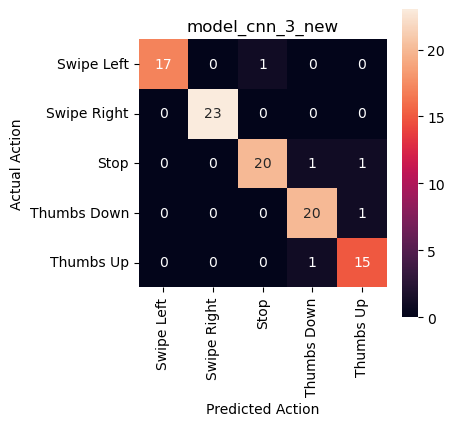

In [42]:
model_cnn_3_new = load_model('model_cnn_3_new.h5')
predictanddraw(model_cnn_3_new,frames,actual,namelist,"model_cnn_3_new")


4/4 [==============================] - 1s 208ms/step

Precision and Recall by Class for model_cnn_3  :

Class Name     Precision  Recall    
Swipe Left     1.000      0.944     
Swipe Right    1.000      1.000     
Stop           0.833      0.909     
Thumbs Down    0.864      0.905     
Thumbs Up      0.857      0.750     

The mean precision of this model is : 0.911
The mean Recall of this model is    : 0.902


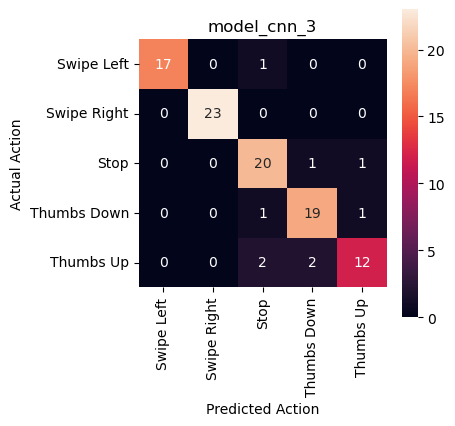

In [43]:
model_cnn_3 = load_model('model_cnn_3.h5')
predictanddraw(model_cnn_3,frames,actual,namelist,"model_cnn_3")

4/4 [==============================] - 1s 210ms/step

Precision and Recall by Class for model_cnn_2  :

Class Name     Precision  Recall    
Swipe Left     0.850      0.944     
Swipe Right    1.000      1.000     
Stop           0.952      0.909     
Thumbs Down    1.000      0.667     
Thumbs Up      0.682      0.938     

The mean precision of this model is : 0.897
The mean Recall of this model is    : 0.892


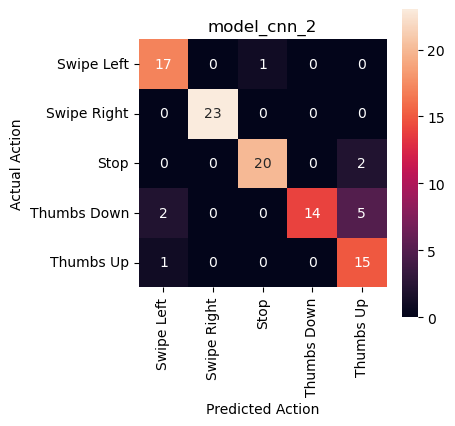

In [44]:
model_cnn_2 = load_model('model_cnn_2.h5')
predictanddraw(model_cnn_2,frames,actual,namelist,"model_cnn_2")